In [ ]:
# imports for PyTorch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import cv2
from skimage.io import imread

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from torch.utils.data import TensorDataset
import torch.nn.functional as F
# If you want to use torchvision for pre-built models and datasets
import torchvision
import torchvision.transforms as transforms

# Other imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

here i used code to create out_dir and copy files with 63% for training Test: 23%
Validation: 14%

In [ ]:
# Mount Google Drive
from google.colab import drive

drive.mount('/content/drive')
# Define the data path
DATA_PATH = '/content/drive/MyDrive/sipakmed/sipakmed/'

Mounted at /content/drive


In [ ]:
import os
import shutil
import random

# Define the subsets (train, validation, and test) and their ratios
subsets = ["train", "val", "test"]
split_ratios = [0.60, 0.20, 0.20]

# Define the class labels
classes = ["normal", "atypical"]

# Create output directories if they don't exist
output_dir = '/content/drive/MyDrive/sipakmed/sipakmed/sipakmed_training'  # Set your desired output directory
for subset in subsets:
    for class_label in classes:
        subset_dir = os.path.join(output_dir, subset, class_label)
        os.makedirs(subset_dir, exist_ok=True)

# Function to check if a file has already been copied
def has_been_copied(file, destination_subset):
    class_name = "normal" if "normal" in file else "atypical"
    dest_path = os.path.join(output_dir, destination_subset, class_name, os.path.basename(file))
    return os.path.exists(dest_path)

# Function to record copied files
def record_copied_files(copied_files, destination_subset):
    with open(f'copied_files_{destination_subset}.txt', 'a') as file:
        for copied_file in copied_files:
            file.write(copied_file + '\n')

# Get a list of all image file paths
drive_path = '/content/drive/MyDrive/sipakmed/sipakmed/'  # Set your input directory containing image files
file_paths = []
for root, dirs, files in os.walk(drive_path):
    for file in files:
        if file.endswith('.bmp'):
            file_paths.append(os.path.join(root, file))

# Initialize empty lists for train, val, and test files
train_files = []
val_files = []
test_files = []

# Loop through each class, organize files, and split the data
for class_label in classes:
    class_dir = os.path.join(drive_path, class_label)
    file_list = [file for file in file_paths if class_label in file]

    # Shuffle the file list for random sampling
    random.shuffle(file_list)

    # Split the data based on the defined ratios
    num_files = len(file_list)
    split_points = [
        0,
        int(split_ratios[0] * num_files),
        int((split_ratios[0] + split_ratios[1]) * num_files),
        num_files,
    ]

    train_files += file_list[split_points[0]:split_points[1]]
    val_files += file_list[split_points[1]:split_points[2]]
    test_files += file_list[split_points[2]:split_points[3]]

def copy_files(source_files, destination_subset):
    copied_files = []
    for file in source_files:
        if not has_been_copied(file, destination_subset):
            class_name = "normal" if "normal" in file else "atypical"
            dest_path = os.path.join(output_dir, destination_subset, class_name, os.path.basename(file))
            if not os.path.exists(dest_path):
                shutil.copy(file, dest_path)
                copied_files.append(file)
                print(f"Copied {file} to {dest_path}")
            else:
                print(f"File {file} already exists in {destination_subset}")
        else:
            print(f"File {file} has already been copied to {destination_subset}")
    return copied_files

i used this to make sure there isn't duplicated data and data for training was succesful

In [ ]:
import os

# Define the path to your original dataset directory
original_dataset_path = '/content/drive/MyDrive/sipakmed/sipakmed/sipakmed_train/'

# Get a list of all image files in the original dataset directory and its subfolders
original_files = []
for root, dirs, files in os.walk(original_dataset_path):
    for filename in files:
        if filename.endswith('.bmp'):
            original_files.append(filename)

# Count the number of unique files in the original dataset
original_file_count = len(original_files)

# List files that are in the current dataset but not in the original
extra_files = []
current_dataset_path = '/content/drive/MyDrive/sipakmed/sipakmed/sipakmed_training/'

for root, dirs, files in os.walk(current_dataset_path):
    for filename in files:
        if filename.endswith('.bmp') and filename not in original_files:
            extra_files.append(os.path.join(root, filename))

if extra_files:
    print("Number of extra files found in the current dataset:", len(extra_files))
    print("Duplicated files found in the current dataset:")
    for file in extra_files:
        print(file)

    # Prompt the user for confirmation before removal
    user_confirmation = input("Do you want to remove these duplicated files? (yes/no): ")

    if user_confirmation.lower() == "yes":
        # Remove the duplicated files
        for extra_file in extra_files:
            os.remove(extra_file)
        print("Duplicated files have been removed.")
    else:
        print("No files have been removed. Your dataset is safe.")
else:
    print("No duplicated files found in the current dataset.")


i used this to check now how many files i have knowing that my data for sipakmed originally were 4049 bmb files

In [ ]:
# Get a list of all image file paths
file_paths = []
categories = []

for root, dirs, files in os.walk(DATA_PATH):
    for file in files:
        if file.endswith('.bmp'):
            file_path = os.path.join(root, file)
            file_paths.append(file_path)
            if 'normal' in file_path:
                categories.append(0)
            else:
                categories.append(1)

In [ ]:
# Create a DataFrame
df = pd.DataFrame({'filename (X)': file_paths, 'category (Y)': categories})
df

In [ ]:
import os
import shutil
import random
# Specify the path to your dataset on Google Drive
drive_path = '/content/drive/MyDrive/sipakmed/sipakmed/'

# Define the output directory for your divided dataset on Google Drive
output_dir = '/content/drive/MyDrive/sipakmed/sipakmed/sipakmed_training'


to check if my data are balanced regarding the training ones or not

In [ ]:
import os
import matplotlib.pyplot as plt

# Define the root directories to check
directories = [
    '/content/drive/MyDrive/sipakmed/sipakmed/sipakmed_training/',
    '/content/drive/MyDrive/sipakmed/sipakmed/'
]

# Function to count BMP files recursively in a directory
def count_bmp_files_recursive(root_dir):
    count = 0
    for root, dirs, files in os.walk(root_dir):
        count += sum(1 for file in files if file.endswith('.bmp'))
    return count

# Iterate over the directories and count the files
counts = []
dir_names = []

for directory in directories:
    file_count = count_bmp_files_recursive(directory)
    counts.append(file_count)
    dir_names.append(directory)
# Print the counts for the specified directories
for name, count in zip(dir_names, counts):
    print(f"Directory: {name}, BMP File Count: {count}")

# Count BMP files in all directories inside both root directories
original_count = count_bmp_files_recursive('/content/drive/MyDrive/sipakmed/sipakmed/')
training_count = count_bmp_files_recursive('/content/drive/MyDrive/sipakmed/sipakmed/sipakmed_training/')

print(f"Total BMP File Count in '/content/drive/MyDrive/sipakmed/sipakmed/': {original_count}")
print(f"Total BMP File Count in '/content/drive/MyDrive/sipakmed/sipakmed/sipakmed_training/': {training_count}")



# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(dir_names + ['Total Original', 'Total Training'], counts + [original_count, training_count], color='skyblue')
plt.xlabel('Directories')
plt.ylabel('BMP File Count')
plt.title('BMP File Counts in Specified Directories')
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()

data balance in normal and atypical

In [ ]:
# Function to balance data by randomly undersampling the majority class
def balance_data(train_files):
    normal_files = [file for file in train_files if 'normal' in file]
    atypical_files = [file for file in train_files if 'atypical' in file]

    min_samples = min(len(normal_files), len(atypical_files))

    balanced_data = random.sample(normal_files, min_samples) + random.sample(atypical_files, min_samples)
    return balanced_data


In [ ]:
def check_balance(data):
    normal_count = sum(1 for file in data if 'normal' in file)
    atypical_count = sum(1 for file in data if 'atypical' in file)

    return normal_count, atypical_count

# Call the balance_data function to get the balanced dataset
balanced_train_data = balance_data(train_files)

# Check the balance
normal_count, atypical_count = check_balance(balanced_train_data)
print(f"Normal samples: {normal_count}, Atypical samples: {atypical_count}")

if normal_count == atypical_count:
    print("The data is balanced.")
else:
    print("The data is not balanced.")


Normal samples: 2179, Atypical samples: 2179
The data is balanced.


Data preprocessing and loading using torchvision


 load images and their labels from the balanced_dataset:

In [ ]:
!pip install Pillow


In [ ]:
import os
import torch
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
from sklearn.metrics import accuracy_score

# Define your parameters
IMAGE_HEIGHT = 125
IMAGE_WIDTH = 125
IMAGE_CHANNELS = 3
DATA_PATH = "/content/drive/MyDrive/sipakmed/sipakmed/sipakmed_training"
BATCH_SIZE = 16
EPOCHS = 50
PATIENCE = 13

# Define your data transformation without data augmentation
transform = transforms.Compose([
    transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Define the path for train, val, and test
train_path = os.path.join(DATA_PATH, 'train')
val_path = os.path.join(DATA_PATH, 'val')
test_path = os.path.join(DATA_PATH, 'test')

# Load the dataset using ImageFolder
train_dataset = ImageFolder(root=train_path, transform=transform)
val_dataset = ImageFolder(root=val_path, transform=transform)
test_dataset = ImageFolder(root=test_path, transform=transform)

# Set up DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Define your MobileNetV3 Small model
model = models.mobilenet_v3_small(pretrained=True)
model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, len(train_dataset.classes))

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Early stopping
best_val_loss = float('inf')
no_improvement_count = 0

# Train the model
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    train_preds = []
    train_labels = []

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        train_preds.extend(predicted.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    train_accuracy = accuracy_score(train_labels, train_preds)

    # Validate the model
    model.eval()
    val_loss = 0.0
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            val_preds.extend(predicted.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)
    val_accuracy = accuracy_score(val_labels, val_preds)

    print(f"Epoch {epoch + 1}, Training Loss: {running_loss / len(train_loader)}, Training Accuracy: {train_accuracy}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improvement_count = 0
    else:
        no_improvement_count += 1

    if no_improvement_count >= PATIENCE:
        print(f"Early stopping at epoch {epoch + 1}")
        break

# Evaluate on test set
model.eval()
test_loss = 0.0
test_preds = []
test_labels = []

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_loss /= len(test_loader)
test_accuracy = accuracy_score(test_labels, test_preds)

print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Save the model
torch.save(model.state_dict(), "mobilenetv3_small.pth")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 28.4MB/s]


Epoch 1, Training Loss: 0.25401450327241465, Training Accuracy: 0.9006469500924215, Validation Loss: 0.29226029626829103, Validation Accuracy: 0.9125168236877523
Epoch 2, Training Loss: 0.1357076711172019, Training Accuracy: 0.9505545286506469, Validation Loss: 0.1264373913383795, Validation Accuracy: 0.9703903095558546
Epoch 3, Training Loss: 0.0976414630525088, Training Accuracy: 0.9662661737523105, Validation Loss: 0.11671414222994152, Validation Accuracy: 0.9623149394347241
Epoch 4, Training Loss: 0.11086580478449297, Training Accuracy: 0.9611829944547134, Validation Loss: 0.05240738922548963, Validation Accuracy: 0.9798115746971736
Epoch 5, Training Loss: 0.08148572629921974, Training Accuracy: 0.9681146025878004, Validation Loss: 0.09300902557295054, Validation Accuracy: 0.9596231493943472
Epoch 6, Training Loss: 0.06652347823140137, Training Accuracy: 0.9750462107208873, Validation Loss: 0.04596528438716942, Validation Accuracy: 0.9851951547779273
Epoch 7, Training Loss: 0.05054

In [ ]:
pip install seaborn matplotlib numpy scikit-learn


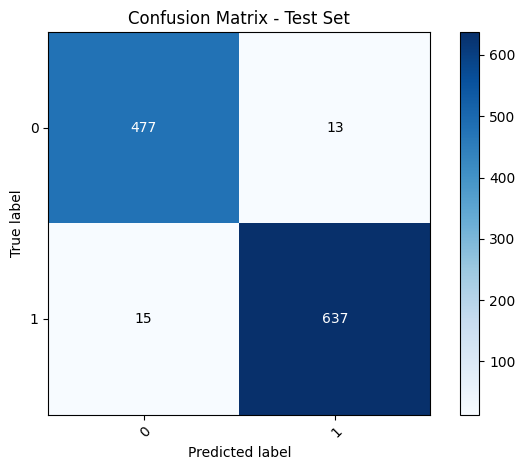

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# Define a function to plot the confusion matrix heatmap
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    classes = unique_labels(y_true, y_pred)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Plot the confusion matrix for the test set
plot_confusion_matrix(test_labels, test_preds, classes=train_dataset.classes, title='Confusion Matrix - Test Set')

plt.show()


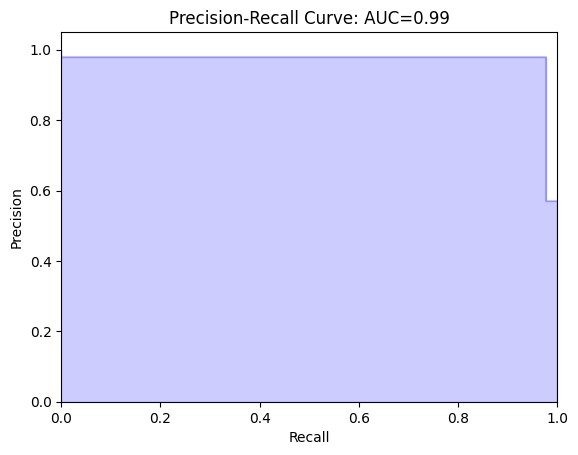

In [ ]:
from sklearn.metrics import precision_recall_curve, auc

precision, recall, _ = precision_recall_curve(test_labels, test_preds)
pr_auc = auc(recall, precision)

plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve: AUC={0:0.2f}'.format(pr_auc))
plt.show()


In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report

# Calculate additional metrics
f1 = f1_score(test_labels, test_preds, average='weighted')
precision = precision_score(test_labels, test_preds, average='weighted')
recall = recall_score(test_labels, test_preds, average='weighted')

print(f"F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

# Print classification report
class_names = [str(i) for i in range(len(train_dataset.classes))]
print("Classification Report:")
print(classification_report(test_labels, test_preds, target_names=class_names))

F1 Score: 0.9755, Precision: 0.9755, Recall: 0.9755
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       490
           1       0.98      0.98      0.98       652

    accuracy                           0.98      1142
   macro avg       0.97      0.98      0.97      1142
weighted avg       0.98      0.98      0.98      1142



Overall, these metrics indicate that your model is performing very well on the test set, with high precision, recall, and F1 score.







In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_params = count_parameters(model)
print(f"Number of trainable parameters in the model: {num_params}")


Number of trainable parameters in the model: 1519906


In [ ]:
import time

# Use a sample input for inference
sample_input = torch.randn(1, IMAGE_CHANNELS, IMAGE_HEIGHT, IMAGE_WIDTH)

# Measure inference time
model.eval()
with torch.no_grad():
    start_time = time.time()
    _ = model(sample_input)
    inference_time = time.time() - start_time

print(f"Inference time for a sample input: {inference_time} seconds")


Inference time for a sample input: 0.013442516326904297 seconds
